# Ship Rudder Design

## 1 The code
Experimental datasets and Xfoil data were manually entered as arrays into the code. In case this code is to be used for another rudder and required to have compared it with experimental and xfoil data it should be modified seperately. 

Each section has a different class written to calculate the parameters related to the section. I.e. all ship parameters are calculated in class "ShipParameters". Similarly "ShipChar", "Rudder", "LR_Rules", "Experimental", calculates the ship characteristics, rudder parameters, Lloyd Register parameters and experimental values, respectively. The classes were also inherited in the same order so that every class can utilise already defined methods(function) in other classes hence reducing the code length and increasing processing efficiency. 


#### The results
All the possible outputs are printed in this sheet to demonstrate the results. 

In [7]:
"""
@author: nisham
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import pandas as pd
sns.set()

#This code calculates the forces and moments on a rudder
class ShipParameters:
    '''
    This class takes in all the geometrical and performance parameters necessary to calculate the 
    ship characteristics and rudder forces
    '''
    ro = 1025
    def __init__(self,flow,lwl,lpp,breadth,draught,disp,speed,PropDia,\
                 PropDist,PropRev,rudderheight,chord_length,\
                     chord_l_root,chord_l_tip,root_gap,omega=0,\
                         Allow_stress=235):
        self.lwl = lwl #length waterline (m)
        self.Lpp = lpp #length between perpendiculars (m)
        self.B = breadth #breadth at waterline (m)
        self.T = draught #scantling draught (m)
        self.Disp = disp #displacement (t)
        self.Volume = (disp*1000)/ShipParameters.ro #volume (m3)
        self.Vs = speed*0.5144 #ship's speed (m/s)
        self.Vs_kn = speed
        self.X = PropDist #distance between propeller and rudder leading edge
        self.Dia = PropDia #propeller diameter
        ########################## revise this value?
        self.n = PropRev/60 #propeller revolution (rpm)
        self.flow = flow #flow type. "freeflow" or "behindhull" (text)
        
        self.sigma = Allow_stress #maximum tensile stress of the rudder stock material
        self.omega = omega #sweep angle (deg)
        self.s = rudderheight #rudder height at center (m)
        self.c = chord_length #mean chord length (m)
        self.cr = chord_l_root #horizontal span at rudder root (m)
        self.ct = chord_l_tip #horizontal span at rudder tip (m)
        self.G = root_gap #the gap between root and hull (m)
        self.r_taper = self.ct/self.cr #taper ratio
        
        #NACA data, profile = 0015
        #This code applies to naca 0015 only. For other profiles the following parameters need to be changed
        self.cdo = 0.0065 #Give details of these parameters
        self.ki = 1/(np.pi*0.9)
        self.e = 0.9
        
        #Flow data
        self.A = self.s*self.c #Rudder area
        #############Do the calculation for area. CORRECT THIS. compare this with recommended areas
        self.ro = 1025
        
        #Secondary rudder parameters
        self.ARg = self.s/self.c #Geometric aspect ratio
        ###################Need to code its automatic calculations
        self.G_c = self.G/self.c #root_gap-chord ratio. Used to calculate k value. 
        self.ARe = self.k_value()*self.ARg
        
    def k_value(self):
        '''
        In this function the the k-value is graph is intrapolated
        '''
        Gc_x = [0.0, 0.002, 0.005, 0.008, 0.011, 0.014, 0.017, 0.021, 0.024, 0.028, 0.032,\
               0.036, 0.041, 0.046, 0.052, 0.058, 0.066, 0.076, 0.086, 0.097, 0.11]
        k_y = [2.0, 2.0, 1.9, 1.9, 1.9, 1.9, 1.8, 1.8, 1.8, 1.8, 1.7, 1.7, 1.7, 1.6, 1.6,\
               1.6, 1.6, 1.5, 1.5, 1.5, 1.5]
        f = interp1d(Gc_x,k_y)
        self.k = f(self.G_c)
        return self.k
    
    def __str__(self):
        return f'Area: {self.A} \nARg: {self.ARg} \nARe: {self.ARe} \nRoot gap ratio: {self.G_c}\
            \nkValue: {self.k_value()}'
        
class ShipChar(ShipParameters):
    '''
    This class calculates the ship characteristics that are necessary for the rudder calculation.
    Ship and rudder dimension class parameters are inherited to this class.
    '''
    def Cb(self):
        '''
        Block Coefficient
        '''
        self.cb = self.Volume/(self.lwl*self.B*self.T) #block coefficient
        return self.cb
    
    def Wt(self):
        '''
        wake fraction based on Harvald formula
        '''
        self.wt = 1.095-(3.4*self.Cb())\
            + (3.3*self.Cb()**2) +\
                ((0.5*(self.Cb()**2)*(6.5-(self.Lpp/self.B)))\
                 /(self.Lpp/self.B)) #wake factor
        return self.wt
    
    def Va_hull(self):
        '''
        Advanced velocity due to hull interactions (m/s). 
        '''
        self.Va = self.Vs*(1-self.Wt())
        return self.Va
    
    def J(self):
        self.j = self.Va_hull()/(self.n*self.Dia) 
        return self.j
    
    def Kt(self):
        '''
        Kt,J curve for Wageningen B4.40 is digitized and converted into arrays of 25 points. 
        The arrays are linear interpolated to find the Kt value for the calculated J
        '''
        J_x = [1.022, 0.9836, 0.9448, 0.9055, 0.8662, 0.8268, 0.7874, 0.7478, 0.7081, 0.6682,\
               0.6279, 0.5874, 0.5465, 0.5053, 0.4639, 0.4224, 0.3808, 0.3391, 0.2973, 0.2553,\
                   0.2131, 0.1708, 0.1284, 0.0858, 0.043, 0.0]
        Kt_y = [0.0, 0.0207, 0.0406, 0.0597, 0.0785, 0.0973, 0.116, 0.1345, 0.1525, 0.1701, 0.187,\
                0.203, 0.2182, 0.2328, 0.2465, 0.2599, 0.273, 0.286, 0.2985, 0.3103, 0.3216, 0.3322,\
                    0.3423, 0.3518, 0.3603, 0.3678]
        f = interp1d(J_x,Kt_y)
        self.kt = f(self.J())
        return self.kt
    
    def Kt_J(self):
        Kt_J = self.Kt()/(self.J()**2)
        return Kt_J
    
    def Va_prop(self):
        '''
        Velocity reduction due to propeller interaction (m/s)
        '''
        self.Kr = 0.5 + (0.5/(1+(0.15/(self.X/self.Dia))))
        self.Vr = self.Va_hull()\
            *(1+self.Kr*(((1+((8*self.Kt())\
                              /(np.pi*(self.J()**2)))**0.5)-1)))
        return self.Vr
    
    def rudder_area(self):
        '''
        Maximum and minimum rudder area recommended by Shiba,1960
        '''
        self.area_max = 0.025*self.Lpp*self.T
        self.area_min = 0.02*self.Lpp*self.T
        #print(f'rudder area range (Shiba,1960) = {self.area_min}-{self.area_max}')
        return self.area_min, self.area_max
    
    def Dnvgl(self):
        '''
        Minimum rudder area recommended by DNV-Gl
        '''
        a = ((self.Lpp*self.T)/100)*(1+50*(self.Cb()**2)*((self.B/self.Lpp)**2))
        return a

class Rudder(ShipChar):
    
    alpha = np.arange(-5,35.1,1.4) #set of turning angles to be analysed
    x1 = np.arange(0.19,0.26,0.01)
    x1 = x1.reshape(len(x1),1) #rudder stock location in ratio of mean chord

    def coefficients(self):
        '''
        Calculates hydrodynamic lift,drag coeffients
        '''
        self.cdc = 0.1 + 1.6*self.ct/self.cr

        self.dclAlpha = (1.8*np.pi*self.ARe)\
            /(57.3 * (np.sqrt((np.cos(np.radians(self.omega)))*(((self.ARe**2)\
            /(np.cos(np.radians(self.omega))**4))+4)) + 1.8))
        if self.flow == "xfoil":
            self.Cl = np.array([-0.5775, -0.4164, -0.2548, -0.0931, 0.0699, 0.2317,\
                                0.3933, 0.5546, 0.7365, 0.8719, 1.0284, 1.1824, 1.3327,\
                                    1.4768, 1.6139, 1.7454, 1.8416, 1.9192, 1.9767,\
                                        2.0075, 1.9996, 1.9195, 1.7635, 1.6081, 1.4714,\
                                            1.374, 1.3056, 1.2696, 1.2704])
        else:
            self.Cl = ((self.dclAlpha * Rudder.alpha) + ((self.cdc/self.ARe)\
                                                         * ((Rudder.alpha/57.3))**2))
                #Lift coefficient
        if self.flow == 'xfoil':
            self.Cd = np.array([0.006, 0.0057, 0.0054, 0.0053, 0.0053, 0.0054, 0.0057,\
                                0.006, 0.0065, 0.0069, 0.0075, 0.0081, 0.0088, 0.0098,\
                                    0.011, 0.0125, 0.0146, 0.0179, 0.0233, 0.0324, 0.0475,\
                                        0.0732, 0.1115, 0.1534, 0.1965, 0.2359, 0.2727,\
                                            0.3045, 0.3258])
        else:
            self.Cd = self.cdo + ((self.Cl**2)/(np.pi*self.e*self.ARe)) #drag coefficient
        self.Cn = (self.Cl*(np.cos(np.radians(Rudder.alpha))))\
            + (self.Cd*(np.sin(np.radians(Rudder.alpha)))) #normal force coefficient
        self.l_d = self.Cl/self.Cd
        return self.Cl,self.Cd,self.l_d,self.dclAlpha,self.Cn,self.cdc
    
    def CPc(self):
        '''
        Transverse Center of Pressure location (ratio) for each turning angle
        '''
        self.Dmc4_dcl = 0.5 - (((1.11*(np.sqrt((self.ARe**2)+4)))+2)\
                               /(4*(self.ARe + 2)))
        if self.flow == 'xfoil':
            self.Cmc4 = np.array([0.0024, 0.0018, 0.0012, 0.0005, -0.0004, -0.0011,\
                                  -0.0017, -0.0024, -0.0027, -0.0029, -0.0029,\
                                      -0.0026, -0.0018, 0.0, 0.0027, 0.0057, 0.0144,\
                                          0.0233, 0.0305, 0.0343, 0.0331, 0.0249, 0.0072,\
                                              -0.0199, -0.0556, -0.092, -0.1268,\
                                                  -0.157, -0.179])
        else:
            self.Cmc4 = ((0.25) - (self.Dmc4_dcl))\
                * (self.coefficients()[3]) * Rudder.alpha\
                    - 0.5*(self.coefficients()[5]/self.ARe)*((Rudder.alpha/57.3)**2)
        self.cpc = 0.25 - (self.Cmc4/self.coefficients()[4]) #Solved
        self.cpc = self.cpc.reshape(len(self.cpc),1)
        return self.cpc,self.Cmc4
    
    def NormalForce(self):
        if self.flow == "freeflow":
            self.normalforce = self.coefficients()[4]*0.5\
                *self.ro*self.A*self.Vs**2 #normal force (N)
        else:
            self.normalforce = self.coefficients()[4]\
                *0.5*self.ro*self.A*self.Va_prop()**2 
            #normal force behind hull and prop (N)
        return self.normalforce
    
    def Torque(self):
        '''
        Torque exerted on the rudder stock for each angle,alpha at each rudder
        stock location x1. Matrix dimension = (nos(x1),nos(alpha))
        '''
        
            
        self.TransLever = self.CPc()[0].T * self.c - self.x1*self.c 
        #transverse lever arm to the stock centerline
        self.torque = self.NormalForce()*self.TransLever #Torque (Nm)
        return self.torque
    
    def CPs(self):
        cps = (0.85/((5+self.ARe)**0.25))*((self.ct/self.cr)**0.11)
        #Vertical CPs location (ratio)
        return cps
 
    def vertlever(self):
        VertLever = self.CPs() * self.s #Vertical CPs location from root (m)
        Vspan = VertLever + self.G
        return Vspan
    
    def Moments(self):
        '''
        Resulting Bending Moment on the rudder stock bearings for each 
        angle,alpha at each rudder stock location x1
        '''
        if self.flow =="freeflow":
            DragForce = np.sqrt((self.coefficients()[0]**2)\
                                     +(self.coefficients()[1]**2))\
                * 0.5 * self.ro * self.A * self.Vs**2 #Drag force (N)
        else:
            DragForce = np.sqrt((self.coefficients()[0]**2)\
                                     +(self.coefficients()[1]**2))\
            * 0.5 * self.ro * self.A * self.Va_prop()**2 \
                #Drag force behind hull and propeller (N)
        moment = DragForce * self.vertlever()
        return moment
    
    def BMe(self):
        bme = (self.Moments()/2) + 0.5*(np.sqrt((self.Moments()**2)+\
                                             (self.Torque()**2)))
        return bme
    
    def QRe(self):
        qre = self.Moments() + (np.sqrt(self.Moments()**2)+\
                                (self.Torque()**2))
        return qre
    
    def Stock_Diameter(self):
        self.MaxTorque = np.max(np.abs(self.Torque()[6]))
        self.MaxMoment = np.max(np.abs(self.Moments()))
        self.BMe = (self.MaxMoment/2)\
            + 0.5*(np.sqrt((self.MaxMoment**2)+(self.MaxTorque**2)))
        k = (235/self.sigma)**0.75
        minstress = self.sigma*k
        self.StockDiameter = ((self.BMe*1000*32)/(np.pi*minstress))**(1/3)
        return self.StockDiameter
        
    def __str__(self):
        return f'Area: {self.A} \nARg: {self.ARg} \nARe: {self.ARe} \nRoot gap ratio: {self.G_c}\
            \nkValue: {self.k_value()} \nCb: {self.Cb()} \nwt: {self.Wt()} \nVa: {self.Va_hull()}\
                \nJ: {self.J()} \nKt: {self.Kt()} \nKt/j2: {self.Kt_J()}: \nVaProp: {self.Va_prop()}\
                    \nShiba Recomm Area: {self.rudder_area()}m2 \nDNVGL recomm Area: {self.Dnvgl()}m2\
                        \nAngles: {self.alpha} \nStockPositions: {self.x1}\nCL: {self.coefficients()[0]}\
                            \nCd: {self.coefficients()[1]} \nCPc: {self.CPc()[0]} \nTorque: {self.Torque()}\
                                \nVerticalLever: {self.vertlever()}m \nMoment: {self.Moments()}\
                                \nEquivBendMom: {self.BMe()} \nEquiTorque: {self.QRe()}\
                                \nStockDiameter: {self.Stock_Diameter()}'

class LR_rules(Rudder):
    
    def LR_force(self):
        hR = self.s
        At = self.A
        lm = (hR**2)/At
        if lm < 2:
            lm = hR**2/At
        else:
            lm = 2
        k1 = (lm+2)/3
        k2_ah = 1.1 #profile coefficient ahead for all NACA-00** series
        k2_as = 0.8 #profile coefficient astern for all NACA-00** series
        k3 = 1.0
        self.CR = 132*k1*k2_ah*k3*At*self.Vs_kn**2
        return self.CR
    
    def LR_torque(self):
        c = self.c
        a = 0.25 #relative centre of pressure (given in table 13.2.3)
        Af = 1.77 #area of the blade forward of the stock centreline
        #########################need to get this area from the design
        k11 = Af/self.A
        r = c*(a - k11) #distance from centre of pressure to centreline of rudder
        qr = self.LR_force()*r
        if qr <= 0.1*self.c * self.LR_force():
            QR = 0.1*self.c * self.LR_force()
        else:
            QR = qr
        return QR
    
    def LR_moment(self):
        '''
        applies to spade rudders only
        ''' 
        hc = self.vertlever()
        M = self.LR_force()*hc
        return M
    
    def LR_diameter(self):
        k = (235/self.sigma)**0.75
        dt = 4.2*((self.LR_torque()*k)**(1/3))
        dc = dt*((1+(4/3*((self.LR_moment()/self.LR_torque())**2)))**(1/6))
        return dc
    
    def __str__(self):
        return f'Area: {self.A} \nARg: {self.ARg} \nARe: {self.ARe} \nRoot gap ratio: {self.G_c}\
            \nkValue: {self.k_value()} \nCb: {self.Cb()} \nwt: {self.Wt()} \nVa: {self.Va_hull()}\
                \nJ: {self.J()} \nKt: {self.Kt()} \nKt/j2: {self.Kt_J()}: \nVaProp: {self.Va_prop()}\
                    \nShiba Recomm Area: {self.rudder_area()}m2 \nDNVGL recomm Area: {self.Dnvgl()}m2\
                                        \nLRForce: {self.LR_force()} \nLRTorque: {self.LR_torque()}\
                                        \nLRMoment: {self.LR_moment()}\nLRDiameter: {self.LR_diameter()}'

class Experimental(Rudder):
    
        
    def Exp_data(self):
        '''
        Experimental data for J= 0.51, Kt/j2 = 0.88, 1460 rpm, V = 10 m/s and
        J= 0.94, Kt/j2 = 0.05, 1460 rpm, V = 10 m/s, respectively
        (Molland and Turnock, 2007)
        Note: for angles for which CPs and CPs data was not aviailable were eliminated
        '''
        
        Angle = np.array([-30.8, -25.8, -20.8, -15.8, -10.8, -5.8, 9.2, 14.2, 19.2, 24.2, 29.2])
        #Experimental data for J= 0.36, Kt/j2 = 2.30, 2100 rpm, V = 10 m/s
        Cl2 = np.array([-4.326, -3.665, -2.945, -2.235, -1.093, -0.808, 1.22, 1.879, 2.526, 3.208, 3.853])
        Cd2 = np.array([1.206, 0.81, 0.486, 0.251, 0.189, 0.012, 0.113, 0.269, 0.483, 0.792, 1.177])
        CPc2 = np.array([22.607, 20.441, 18.879, 17.884, 42.852, 20.901, 7.803, 9.987, 12.825, 15.779, 18.989])
        CPs2 = np.array([47.906, 46.999, 45.633, 43.416, 36.601, 30.619, 71.94, 66.444, 64.18, 62.452, 61.565])
        Cmz2 = np.array([0.32, 0.349, 0.325, 0.268, -0.143, 0.073, -0.271, -0.377, -0.437, -0.462, -0.433])
        Cmx2 = np.array([-2.798, -2.331, -1.829, -1.339, -0.612, -0.384, 1.09, 1.581, 2.074, 2.589, 3.086])
        Cmy2 = np.array([0.841, 0.591, 0.386, 0.23, -0.007, 0.055, 0.107, 0.213, 0.363, 0.579, 0.859])
        #Experimental data for J= 0.51, Kt/j2 = 0.88, 1460 rpm, V = 10 m/s
        Cl1 = np.array([-2.668, -2.535, -2.062, -1.56, -1.068, -0.579, 0.848, 1.321, 1.8, 2.244, 2.619])
        Cd1 = np.array([0.903, 0.552, 0.348, 0.198, 0.101, 0.05, 0.114, 0.217, 0.368, 0.577, 0.903])
        CPc1 = np.array([31.912, 23.149, 20.766, 19.145, 18.789, 19.665, 13.422, 16.827, 19.355, 22.1, 27.239])
        CPs1 = np.array([45.237, 47.216, 46.065, 44.28, 40.892, 34.284, 62.958, 59.708, 57.783, 57.031, 56.049])
        Cmz1 = np.array([-0.053, 0.172, 0.189, 0.169, 0.12, 0.06, -0.142, -0.176, -0.194, -0.18, -0.075])
        Cmx1 = np.array([-1.644, -1.622, -1.298, -0.955, -0.619, -0.297, 0.683, 1.025, 1.364, 1.687, 1.955])
        Cmy1 = np.array([0.617, 0.395, 0.254, 0.154, 0.084, 0.051, 0.084, 0.149, 0.251, 0.397, 0.612])
        
        ktj2 = 2.30
        ktj1 = 0.88
        Cl3 = Cl2 - (((Cl2-Cl1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        Cd3 = Cd2 - (((Cd2-Cd1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        CPc3 = CPc2 - (((CPc2-CPc1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        CPs3 = CPs2 - (((CPs2-CPs1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        Cmz3 = Cmz2 - (((Cmz2-Cmz1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        Cmx3 = Cmx2 - (((Cmx2-Cmx1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        Cmy3 = Cmy2 - (((Cmy2-Cmy1)/(ktj2-ktj1))*(ktj2-self.Kt_J()))
        #Cl correction for Aspect ratio
        ARe_exp = 3
        Cl_corr = ((1+(3/ARe_exp))/(1+(3/self.ARe)))*Cl3
        Cd_corr = ((1+(3/ARe_exp))/(1+(3/self.ARe)))*Cd3
        return Angle,Cl_corr,Cl3,Cd_corr,Cd3,CPc3,CPs3

    def Exp_Torque(self):
        '''
        Torque
        '''
        dclalpha = self.coefficients()[3] #rate of change of CL
        CPc3 = self.Exp_data()[5]/100
        theta = self.Exp_data()[0]
        corrset = np.ones(11)
        corrset[4]*1.023
        CPc3 = corrset*CPc3
        dclAlpha_corr = dclalpha*1.005
        self.Cl_corr = ((dclAlpha_corr * theta) + ((self.cdc/self.ARe)\
             * ((theta/57.3))**2)) #Lift coefficient
        self.Cd_corr = self.cdo + ((self.Cl_corr**2)/(np.pi*self.e*self.ARe)) #drag coefficient
        self.Cn_corr = (self.Cl_corr*(np.cos(np.radians(theta))))+ (self.Cd_corr*(np.sin(np.radians(theta))))
        #normal force coefficient
        self.l_d_corr = self.Cl_corr/self.Cd_corr #Cl/Cd 
        self.NF_corr = self.Cn_corr\
            *0.5*self.ro*self.A*self.Va_hull()**2 #corrected normal force behind hull and prop (N)
        self.TL_corr = CPc3.T * self.c - Rudder.x1*self.c #transverse lever arm to the stock centerline
        self.torque_corr = self.NF_corr*self.TL_corr #Torque (Nm)
        return self.torque_corr
    
    def Exp_Moment(self):
        cl = self.Exp_data()[1]
        cd = self.Exp_data()[3]
        self.DF_corr = np.sqrt((cl**2)\
                                 +(cd**2))\
            * 0.5 * self.ro * self.A * self.Va_prop()**2 #Drag force behind hull and propeller (N)
        corrset = np.ones(11)
        corrset[4]*1.000
        self.CPs = (0.85/((5+self.ARe)**0.25))*((self.ct/self.cr)**0.11)
        CPs_corr = corrset*self.CPs
        #Vertical CPs location (ratio)
        self.VL_corr = CPs_corr * self.s #Vertical CPs location from root (m)
        self.moment_corr = self.DF_corr * (self.VL_corr + self.G)
        return self.moment_corr
    
    def Exp_diameter(self):
        MaxTorque = np.max(np.abs(self.Exp_Torque()[6]))
        MaxMoment = np.max(np.abs(self.Exp_Moment()))
        BMe = (MaxMoment/2)\
            + 0.5*(np.sqrt((MaxMoment**2)+(MaxTorque**2)))
        k = (235/self.sigma)**0.75
        minstress = self.sigma*k
        StockDiameter = ((BMe*1000*32)/(np.pi*minstress))**(1/3)
        return StockDiameter
    
    def __str__(self):
        return f'Area: {self.A} \nARg: {self.ARg} \nARe: {self.ARe} \nRoot gap ratio: {self.G_c}\
            \nkValue: {self.k_value()} \nCb: {self.Cb()} \nwt: {self.Wt()} \nVa: {self.Va_hull()}\
                \nJ: {self.J()} \nKt: {self.Kt()} \nKt/j2: {self.Kt_J()}: \nVaProp: {self.Va_prop()}\
                    \nShiba Recomm Area: {self.rudder_area()}m2 \nDNVGL recomm Area: {self.Dnvgl()}m2\
                        \nAngles: {self.alpha} \nStockPositions: {self.x1}\nCL: {self.coefficients()[0]}\
                            \nCd: {self.coefficients()[1]} \nCPc: {self.CPc()} \nTorque: {self.Torque()}Nm\
                                \nVerticalLever: {self.vertlever()}m \nMoment: {self.Moments()[-2]}Nm\
                                \nEquivBendMom: {self.BMe()}Nm \nEquiTorque: {self.QRe()}Nm\
                                \n############################################\n\
                                \nExp_Torque: {self.Exp_Torque()}Nm \nExp_Diameter: {self.Exp_diameter()}mm'
    
rudder_freeflow = Rudder(flow='freeflow',rudderheight=2.634,chord_length=2.691,
                         chord_l_root=2.691,chord_l_tip=2.691,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)

rudder_xfoil = Rudder(flow='xfoil',rudderheight=2.634,chord_length=2.691,
                         chord_l_root=2.691,chord_l_tip=2.691,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)

rudder_hull = Rudder(flow='behindhull',rudderheight=2.634,chord_length=2.691,
                         chord_l_root=2.691,chord_l_tip=2.691,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)

rudder_hull_LR = LR_rules(flow='behindhull',rudderheight=2.634,chord_length=2.691,
                         chord_l_root=2.691,chord_l_tip=2.691,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)

rudder_Exp = Experimental(flow='behindhull',rudderheight=2.634,chord_length=2.691,
                         chord_l_root=2.691,chord_l_tip=2.691,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)


LR1 = LR_rules(flow='behindhull',rudderheight=2.953,chord_length=2.514,
                         chord_l_root=2.709,chord_l_tip=2.414,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)

LR3 = LR_rules(flow='behindhull',rudderheight=2.634,chord_length=2.557,
                         chord_l_root=2.691,chord_l_tip=2.423,root_gap=0.050,
                         omega=0,Allow_stress=390,lwl=95,lpp=91.2,breadth=15.8,
                         draught=3.3,disp=3400,speed=23,PropDia=2.398,
                         PropDist=0.480,PropRev=420)
def datasets(a,b):
    '''
    please pass only the freeflow, xfoil and behind hull data
    write b =1, for freeflow and behind hull conditions and b = any other number for 
    xfoil
    '''
    if b==1:
        df = pd.DataFrame(list(zip(a.alpha,a.coefficients()[0].round(2),
                                    a.coefficients()[1].round(2),a.coefficients()[2].round(2),
                                    a.CPc()[0].round(4),a.CPc()[1].round(3),
                                    a.Torque()[0].round(2),a.Torque()[1].round(2),
                                    a.Torque()[2].round(2),a.Torque()[3].round(2),
                                    a.Torque()[4].round(2),a.Torque()[5].round(2),
                                    a.Torque()[6].round(2),a.Torque()[7].round(2),
                                    a.Moments().round(2))),\
                           columns = ['Angle','Cl','Cd','Cl/Cd','CPc','Cmc4','Trq 19%','Trq 20%','Trq 21%',\
                                      'Trq 22%','Trq 23%','Trq 24%','Trq 25%','Trq 26%','Moment'])
    else:
        df = pd.DataFrame(list(zip(a.alpha,a.coefficients()[0].round(2),
                                    a.coefficients()[1].round(2),a.coefficients()[2].round(2),
                                    a.CPc()[0].round(4),a.CPc()[1].round(3))),\
                           columns = ['Angle','Cl','Cd','Cl/Cd','CPc','Cmc4'])
    plt.figure(figsize=(16, 10))
    plt.subplot(321)
    plt.plot(df['Angle'], df['Cl'])
    plt.xlabel('Angle of attack')
    plt.ylabel('Cl')
    
    plt.subplot(323)
    plt.plot(df['Angle'], df['Cd'])
    plt.xlabel('Angle of attack')
    plt.ylabel('Cd')
    
    
    plt.subplot(325)
    plt.plot(df['Angle'], df['Cl/Cd'])
    plt.xlabel('Angle of attack')
    plt.ylabel('Cl/Cd')
    
    
    plt.subplot(222)
    plt.plot(df['Angle'], df['CPc'])
    plt.xlabel('Angle of attack')
    plt.ylabel('CPc')
        
    plt.subplot(224)
    plt.plot(df['Angle'], df['Cmc4'])
    plt.xlabel('Angle of attack')
    plt.ylabel('Cmc4')
    
    if b == 1:
        plt.figure(figsize=(16, 10))
        plt.plot(df['Angle'], df['Trq 19%'], label= 'Trq 19%')
        plt.plot(df['Angle'], df['Trq 20%'], label= 'Trq 20%')
        plt.plot(df['Angle'], df['Trq 21%'], label= 'Trq 21%')
        plt.plot(df['Angle'], df['Trq 22%'], label= 'Trq 22%')
        plt.plot(df['Angle'], df['Trq 23%'], label= 'Trq 23%')
        plt.plot(df['Angle'], df['Trq 24%'], label= 'Trq 24%')
        plt.plot(df['Angle'], df['Trq 25%'], label= 'Trq 25%')
        plt.plot(df['Angle'], df['Trq 26%'], label= 'Trq 26%')
        plt.legend()
        plt.xlabel('Angle of attack, degrees')
        plt.ylabel('Torque, Nm')
    
    if b == 1:
        plt.figure(figsize=(16, 10))
        plt.plot(df['Angle'], df['Moment'], label= 'Moment')
        plt.xlabel('Angle of attack, degrees')
        plt.ylabel('Moment, Nm')
    return df

def datasets_exp(a):
    '''
    Pass only experimental data here
    '''
    alpha = a.Exp_data()[0]
    Cl_corr = a.Exp_data()[1]
    Cl = a.Exp_data()[2]
    Cd = a.Exp_data()[4]
    Cd_corr = a.Exp_data()[3]
    Cl_Cd = Cl/Cd
    Cl_Cd_corr = Cl_corr/Cd_corr
    CPc = a.Exp_data()[5]
    CPs = a.Exp_data()[6]
    moment = a.Exp_Moment()
    Trq19,Trq20,Trq21,Trq22,Trq23,Trq24,Trq25,Trq26 = [i for i in a.Exp_Torque()]
    df = pd.DataFrame(list(zip(alpha,Cl.round(3),Cl_corr.round(3),Cd.round(3),Cd_corr.round(3),Cl_Cd.round(3),\
                               Cl_Cd_corr.round(3),Trq19.round(3),Trq20.round(3),Trq21.round(3),Trq22.round(3),\
                               Trq23.round(3),Trq24.round(3),Trq25.round(3),Trq26.round(3),CPc.round(3),CPs.round(3),\
                      moment.round(3))),
                           columns = ['Angle','Cl','Cl_corr','Cd','Cd_corr','Cl_Cd','Cl_Cd_corr','Trq 19%',\
                                      'Trq 20%','Trq 21%','Trq 22%','Trq 23%','Trq 24%','Trq 25%','Trq 26%','CPc','CPs',\
                                          'Moment'])
        
    plt.figure(figsize=(16, 10))
    plt.subplot(321)
    plt.plot(alpha, Cl_corr)
    plt.xlabel('Angle of attack')
    plt.ylabel('Cl_corr')
    
    plt.subplot(323)
    plt.plot(alpha, Cd_corr)
    plt.xlabel('Angle of attack')
    plt.ylabel('Cd_corr')
    
    plt.subplot(325)
    plt.plot(alpha, Cl_Cd_corr)
    plt.xlabel('Angle of attack')
    plt.ylabel('Cl_Cd_corr')
    
    plt.subplot(222)
    plt.plot(alpha, CPc)
    plt.xlabel('Angle of attack')
    plt.ylabel('CPc_corr')
    
    plt.subplot(224)
    plt.plot(alpha, CPs)
    plt.xlabel('Angle of attack')
    plt.ylabel('CPs')
    
    plt.figure(figsize=(16, 10))
    plt.plot(df['Angle'], df['Trq 19%'], label= 'Trq 19%')
    plt.plot(df['Angle'], df['Trq 20%'], label= 'Trq 20%')
    plt.plot(df['Angle'], df['Trq 21%'], label= 'Trq 21%')
    plt.plot(df['Angle'], df['Trq 22%'], label= 'Trq 22%')
    plt.plot(df['Angle'], df['Trq 23%'], label= 'Trq 23%')
    plt.plot(df['Angle'], df['Trq 24%'], label= 'Trq 24%')
    plt.plot(df['Angle'], df['Trq 25%'], label= 'Trq 25%')
    plt.plot(df['Angle'], df['Trq 26%'], label= 'Trq 26%')
    plt.legend()
    plt.xlabel('Angle of attack, degrees')
    plt.ylabel('Torque, Nm')
    
    plt.figure(figsize=(16, 10))
    plt.plot(df['Angle'], df['Moment'], label= 'Moment')
    plt.xlabel('Angle of attack, degrees')
    plt.ylabel('Moment, Nm')
    return df
    



-----------------------------------------------End of Code--------------------------------------------------------------

## 2. Results

### 2.1 Empirical Method (Freeflow data)
The following table represents the coefficients, Torque and moment for the rudder calculated using Empirical method in freeflow.

,Angle,Cl,Cd,Cl/Cd,CPc,Cmc4,Trq 19%,Trq 20%,Trq 21%,Trq 22%,Trq 23%,Trq 24%,Trq 25%,Trq 26%,Moment
0,-5.0,-0.19,0.01,-13.83,[0.148],-0.019,10793.61,13363.58,15933.54,18503.50,21073.46,23643.43,26213.39,28783.35,137386.93
1,-3.6,-0.14,0.01,-13.33,[0.1545],-0.013,6633.43,8504.57,10375.72,12246.86,14118.00,15989.14,17860.29,19731.43,100024.80
2,-2.2,-0.08,0.01,-10.63,[0.1609],-0.008,3359.04,4515.09,5671.14,6827.19,7983.25,9139.30,10295.35,11451.40,61888.94
3,-0.8,-0.03,0.01,-4.63,[0.1672],-0.003,969.06,1393.98,1818.90,2243.82,2668.74,3093.66,3518.57,3943.49,23169.86
4,0.6,0.02,0.01,3.55,[0.1733],0.002,-537.63,-859.70,-1181.76,-1503.83,-1825.90,-2147.97,-2470.04,-2792.11,17833.68
5,2.0,0.08,0.01,10.19,[0.1793],0.006,-1161.89,-2246.66,-3331.42,-4416.19,-5500.96,-6585.72,-7670.49,-8755.26,58098.44
6,3.4,0.14,0.01,13.31,[0.1851],0.009,-904.31,-2767.39,-4630.47,-6493.54,-8356.62,-10219.70,-12082.78,-13945.85,99598.61
7,4.8,0.19,0.01,13.80,[0.1909],0.011,234.79,-2422.16,-5079.10,-7736.05,-10393.00,-13049.95,-15706.90,-18363.85,142030.30
8,6.2,0.25,0.02,13.08,[0.1965],0.014,2255.41,-1210.97,-4677.35,-8143.73,-11610.11,-15076.49,-18542.86,-22009.24,185381.46
9,7.6,0.31,0.03,11.96,[0.202],0.015,5157.80,866.39,-3425.02,-7716.43,-12007.84,-16299.25,-20590.66,-24882.07,229665.75


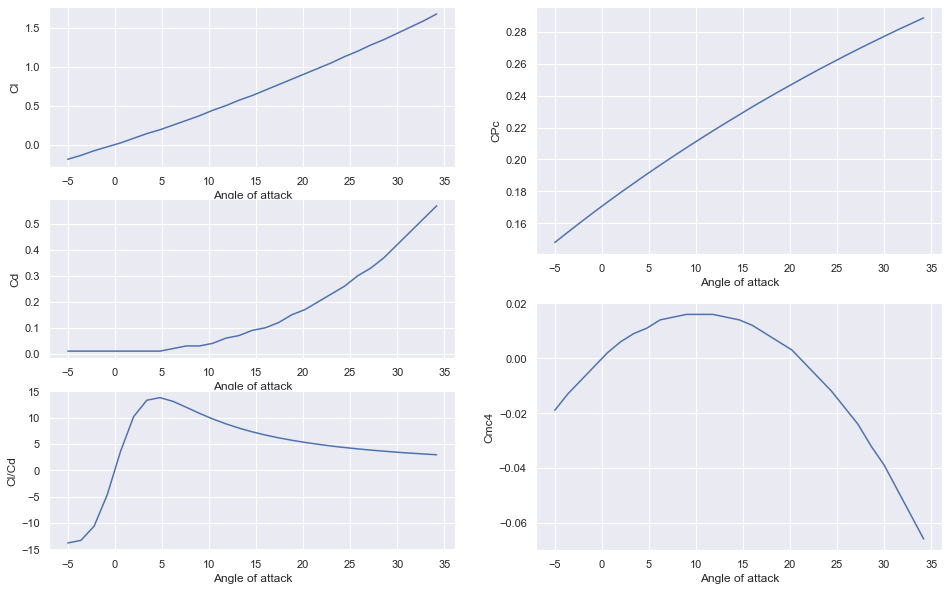

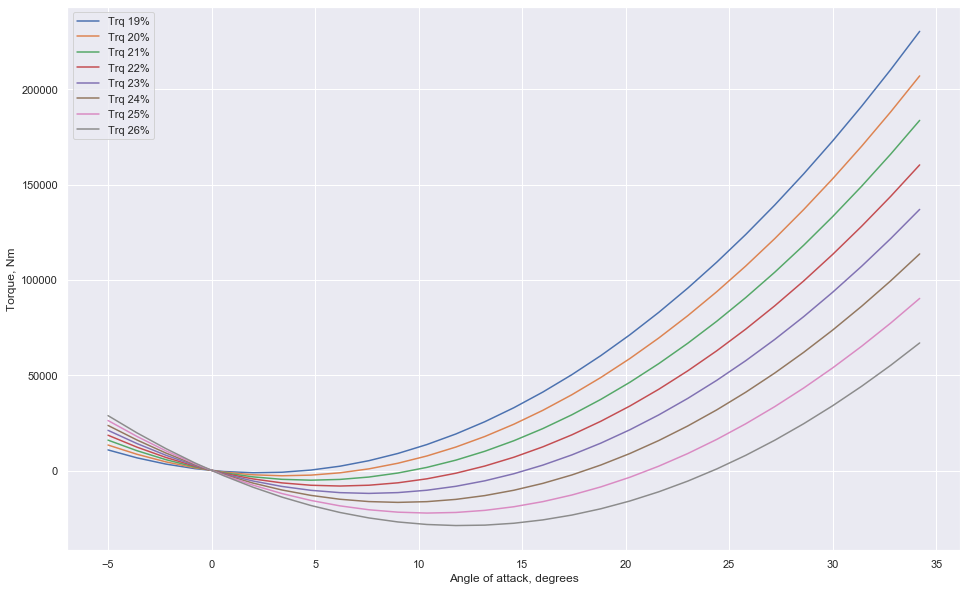

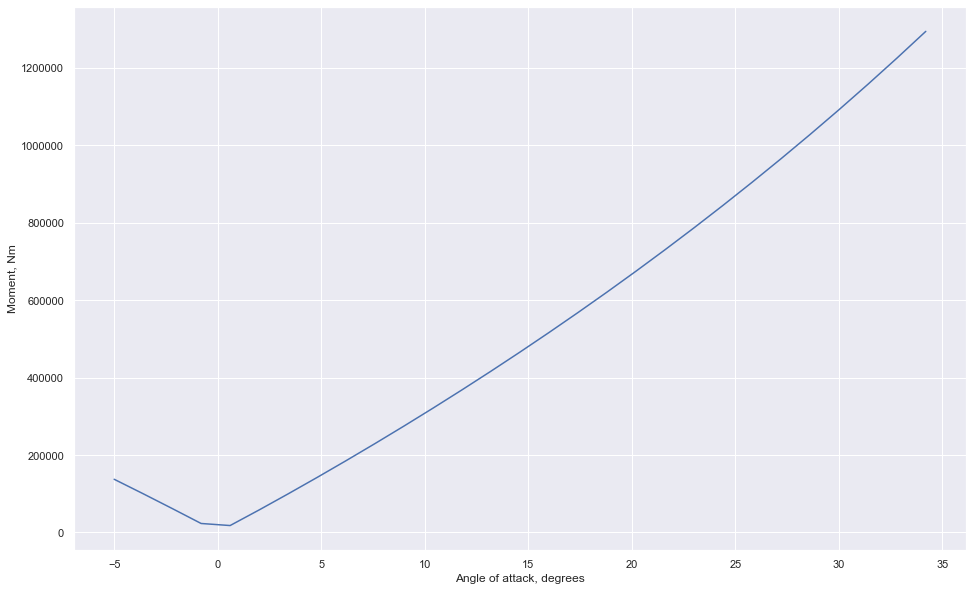

In [2]:
datasets(rudder_freeflow,1)

### 2.2 XFoil Data
The following table represents the coefficients, Torque and moment for the rudder calculated using XFoil in freestream. 

,Angle,Cl,Cd,Cl/Cd,CPc,Cmc4
0,-5.0,-0.58,0.01,-96.25,[0.2542],0.002
1,-3.6,-0.42,0.01,-73.05,[0.2543],0.002
2,-2.2,-0.25,0.01,-47.19,[0.2547],0.001
3,-0.8,-0.09,0.01,-17.57,[0.2554],0.000
4,0.6,0.07,0.01,13.19,[0.2557],-0.000
5,2.0,0.23,0.01,42.91,[0.2547],-0.001
6,3.4,0.39,0.01,69.00,[0.2543],-0.002
7,4.8,0.55,0.01,92.43,[0.2543],-0.002
8,6.2,0.74,0.01,113.31,[0.2537],-0.003
9,7.6,0.87,0.01,126.36,[0.2534],-0.003


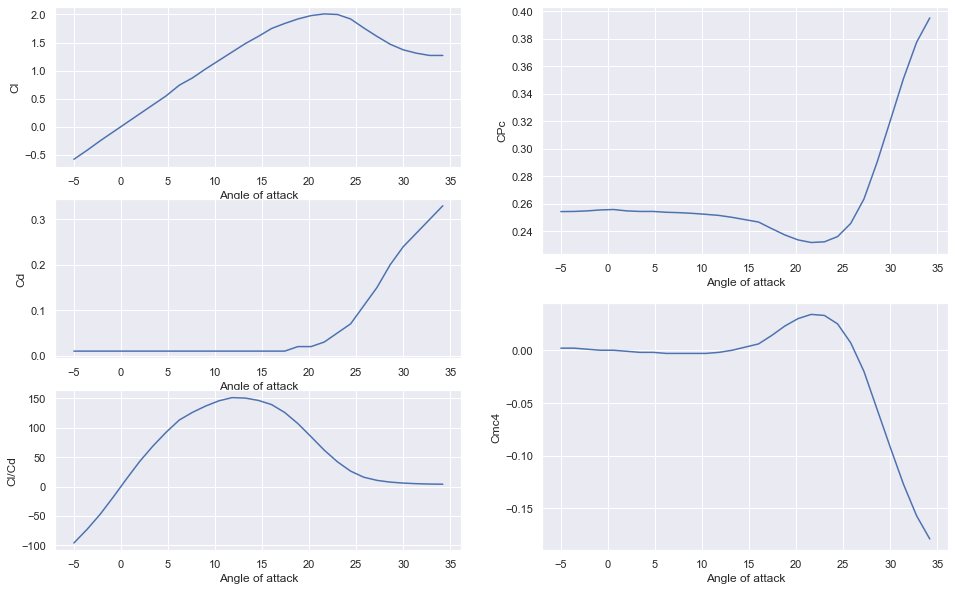

In [3]:
datasets(rudder_xfoil,2)

### 2.3 Empirical Method (Behind Hull)
The following table represents the coefficients, Torque and moment for the rudder calculated using Empirical Method in behind propeller and hull condition. 

,Angle,Cl,Cd,Cl/Cd,CPc,Cmc4,Trq 19%,Trq 20%,Trq 21%,Trq 22%,Trq 23%,Trq 24%,Trq 25%,Trq 26%,Moment
0,-5.0,-0.19,0.01,-13.83,[0.148],-0.019,25948.55,32126.91,38305.27,44483.63,50661.98,56840.34,63018.70,69197.06,330287.18
1,-3.6,-0.14,0.01,-13.33,[0.1545],-0.013,15947.21,20445.55,24943.90,29442.25,33940.60,38438.95,42937.30,47435.65,240466.16
2,-2.2,-0.08,0.01,-10.63,[0.1609],-0.008,8075.35,10854.58,13633.80,16413.02,19192.25,21971.47,24750.69,27529.92,148785.07
3,-0.8,-0.03,0.01,-4.63,[0.1672],-0.003,2329.69,3351.22,4372.75,5394.29,6415.82,7437.35,8458.88,9480.42,55701.86
4,0.6,0.02,0.01,3.55,[0.1733],0.002,-1292.49,-2066.77,-2841.04,-3615.31,-4389.59,-5163.86,-5938.13,-6712.41,42873.32
5,2.0,0.08,0.01,10.19,[0.1793],0.006,-2793.26,-5401.11,-8008.96,-10616.81,-13224.66,-15832.51,-18440.36,-21048.21,139672.46
6,3.4,0.14,0.01,13.31,[0.1851],0.009,-2174.02,-6652.98,-11131.94,-15610.91,-20089.87,-24568.83,-29047.79,-33526.75,239441.57
7,4.8,0.19,0.01,13.80,[0.1909],0.011,564.46,-5823.02,-12210.50,-18597.98,-24985.46,-31372.94,-37760.42,-44147.90,341450.13
8,6.2,0.25,0.02,13.08,[0.1965],0.014,5422.15,-2911.25,-11244.66,-19578.06,-27911.46,-36244.86,-44578.26,-52911.66,445669.17
9,7.6,0.31,0.03,11.96,[0.202],0.015,12399.69,2082.85,-8233.98,-18550.81,-28867.64,-39184.47,-49501.30,-59818.14,552131.49


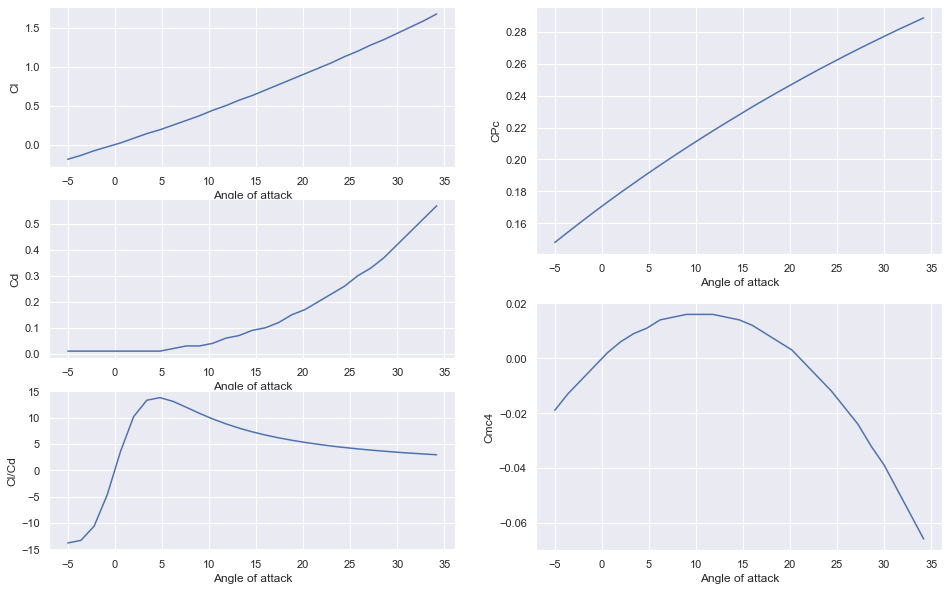

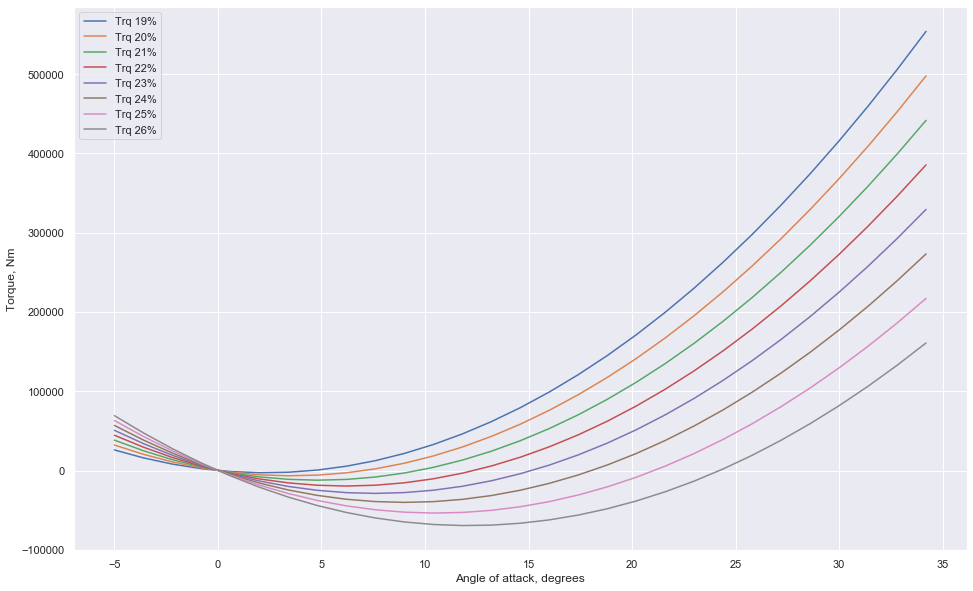

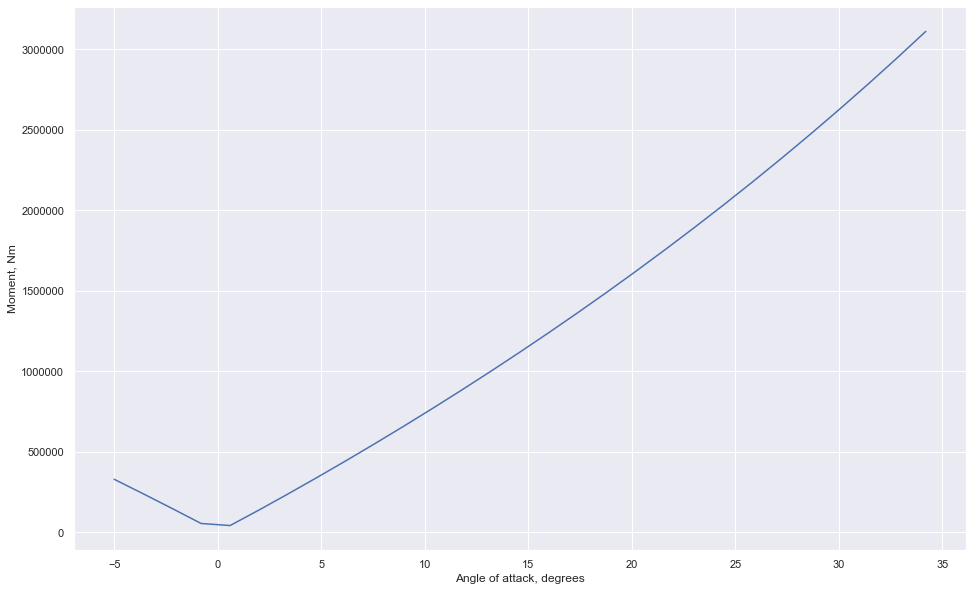

In [4]:
datasets(rudder_hull,1)

### 2.3 Experimental Method (Behind Hull)
The following table represents the coefficients, Torque and moment for the rudder calculated using Experimental method in behind propeller and hull condition. 

,Angle,Cl,Cl_corr,Cd,Cd_corr,Cl_Cd,Cl_Cd_corr,Trq 19%,Trq 20%,Trq 21%,Trq 22%,Trq 23%,Trq 24%,Trq 25%,Trq 26%,CPc,CPs,Moment
0,-30.8,-2.898,-2.145,0.945,0.699,-3.067,-3.067,-64038.650,-58527.400,-53016.150,-47504.900,-41993.650,-36482.400,-30971.150,-25459.900,30.620,45.608,3966613.150
1,-25.8,-2.692,-1.992,0.588,0.435,-4.579,-4.579,-18595.217,-13666.570,-8737.922,-3809.275,1119.373,6048.020,10976.667,15905.315,22.773,47.186,3585242.399
2,-20.8,-2.185,-1.617,0.367,0.272,-5.950,-5.950,-6332.541,-2121.833,2088.875,6299.583,10510.291,14720.999,18931.708,23142.416,20.504,46.005,2882474.653
3,-15.8,-1.654,-1.224,0.205,0.152,-8.053,-8.053,101.523,3469.798,6838.074,10206.349,13574.624,16942.899,20311.175,23679.450,18.970,44.160,2168353.030
4,-10.8,-1.071,-0.793,0.113,0.084,-9.463,-9.463,-7552.213,-5140.231,-2728.249,-316.266,2095.716,4507.699,6919.681,9331.663,22.131,40.296,1401938.891
5,-5.8,-0.611,-0.452,0.045,0.033,-13.658,-13.658,-1130.611,220.714,1572.039,2923.364,4274.689,5626.014,6977.340,8328.665,19.837,33.775,796895.068
6,9.2,0.900,0.666,0.114,0.084,7.901,7.901,-15232.478,-17628.114,-20023.751,-22419.388,-24815.024,-27210.661,-29606.297,-32001.934,12.642,64.206,1179965.616
7,14.2,1.399,1.035,0.224,0.166,6.237,6.237,-11954.818,-15782.796,-19610.774,-23438.752,-27266.730,-31094.708,-34922.686,-38750.664,15.877,60.644,1842939.455
8,19.2,1.901,1.407,0.384,0.284,4.950,4.950,-2957.595,-8315.992,-13674.390,-19032.787,-24391.184,-29749.582,-35107.979,-40466.376,18.448,58.671,2523282.364
9,24.2,2.378,1.760,0.607,0.449,3.918,3.918,15545.904,8549.777,1553.650,-5442.476,-12438.603,-19434.729,-26430.856,-33426.983,21.222,57.784,3193232.114


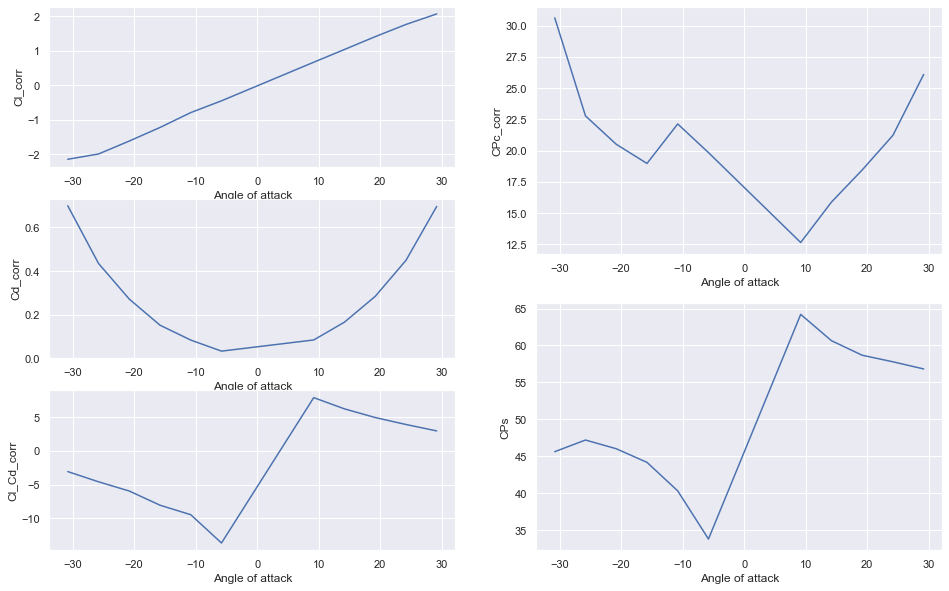

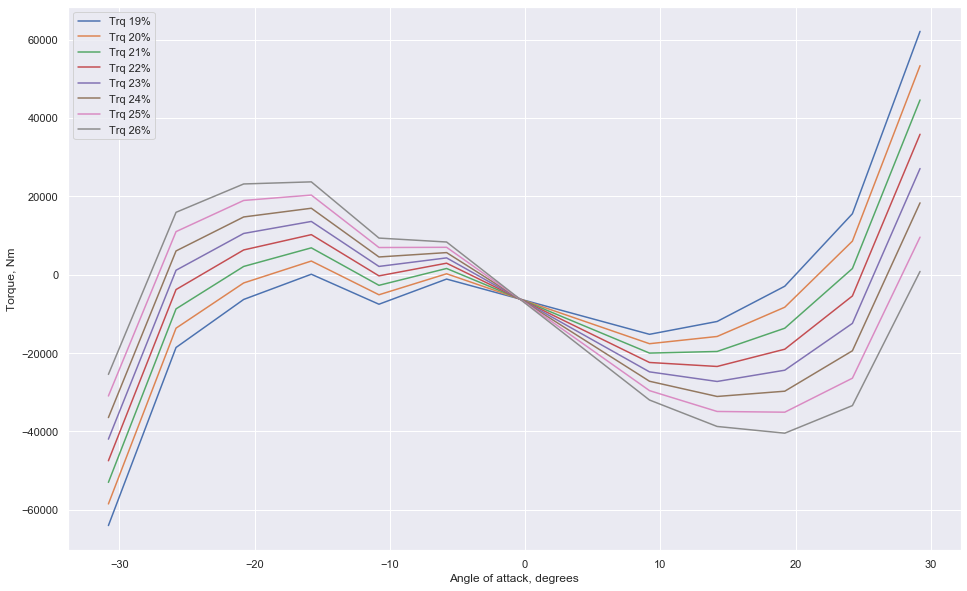

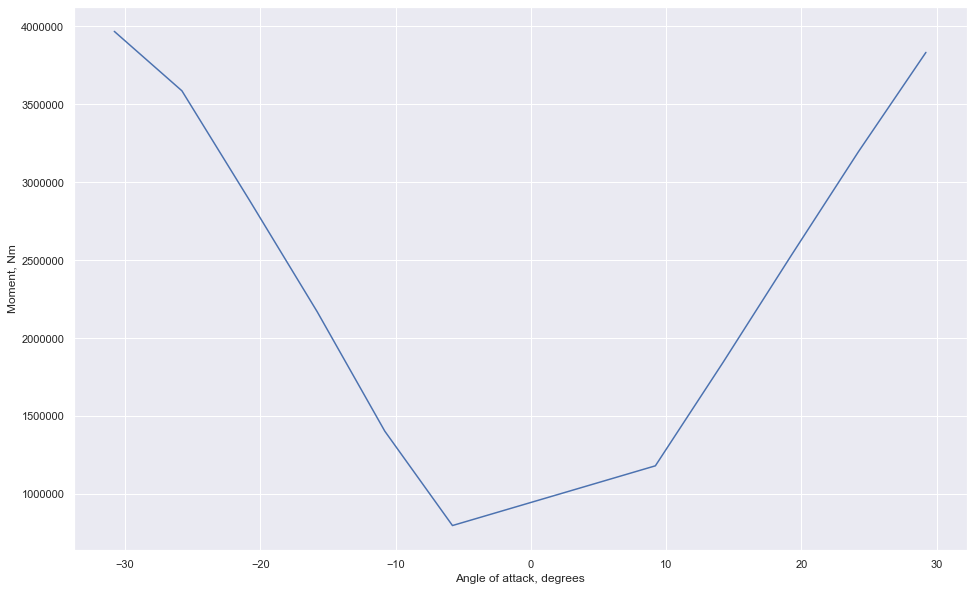

In [5]:
datasets_exp(rudder_Exp)

### 2.3 Lloyd Register Calculation data (Behind Hull)
The following table represents the coefficients, Torque and moment for the rudder calculated using Lloyd Register recommendations using behind propeller and hull velocity flow. 

In [8]:
print(rudder_hull_LR)

Area: 7.088093999999999 
ARg: 0.9788182831661093 
ARe: 1.7618729096989967 
Root gap ratio: 0.01858045336306206            
kValue: 1.8 
Cb: 0.6696693458364539 
wt: 0.32630686138938997 
Va: 7.970598261529848                
J: 0.47483606943463885 
Kt: 0.24288105914844077 
Kt/j2: 1.0772245572480588: 
VaProp: 18.34433369597535                    
Shiba Recomm Area: (6.0192, 7.524)m2 
DNVGL recomm Area: 5.035062089179464m2                                        
LRForce: 540598.0973184002 
LRTorque: 145474.9479883815                                        
LRMoment: 777602.0761755597
LRDiameter: 358.5374552174371


### 2.3 All output
Run the following codes to find all the inside parameters of the functions used above.

print(rudder_freeflow),
print(rudder_hull),
print(rudder_hull_LR),
print(rudder_xfoil),
print(rudder_Exp)